<a href="https://www.kaggle.com/aminizahra/normalized-prediction-distribution-errors-npde?scriptVersionId=88419892" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Import Library**

In [1]:
import copy 
import warnings
import numpy as np 
import matplotlib.ticker as ticker
import scipy.sparse 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.spatial
from matplotlib.colors import ListedColormap
from matplotlib import cm
from scipy.stats import multivariate_normal
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
import math 
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing 
from sklearn.metrics import accuracy_score

# **Creat and load data**

In [2]:
def load_data(mu1, cov1, n1, mu2, cov2, n2, mu3, cov3, n3):
    x1 = np.random.multivariate_normal(mu1, cov1, n1)
    y1 = np.empty((n1,1), dtype = 'int')
    y1[:,:] = 0 
    
    x2 = np.random.multivariate_normal(mu2, cov2, n2)
    y2 = np.empty((n2,1), dtype = 'int')
    y2[:,:] = 1
    
    x3 = np.random.multivariate_normal(mu3, cov3, n3)
    y3 = np.empty((n3,1), dtype = 'int')
    y3[:,:] = 2
    
    x = np.append(np.append(x1, x2, axis=0), x3, axis=0)
    y = np.append(np.append(y1, y2, axis=0), y3, axis=0)
    
    X_train = x
    y_train = y
    
    m = X_train.shape[0]
    
    k = 3
    
    return X_train, y_train, m, k

# **Split data**

In [3]:
def split_data(x, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=20)
    
    m = X_train.shape[0]
    mtest = X_test.shape[0]
    
    k = 3
    
    return X_train, y_train, m, X_test, y_test, mtest, k

# **Define onehot Key**

In [4]:
def to_onehot(Y): 
    m = Y.shape[0] 
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y[:,0], np.array(range(m))))) 
    OHX = np.array(OHX.todense()).T 
    return OHX

# **Define our inputs**

In [5]:
def qda_learn(x, y, m, k, n):    
    #----------------
    onehot_y = to_onehot(y)
    #----------------
    fi = np.zeros((k,1))
    for i in range(0, k):
        temp = 0.
        for j in range(0, m):
            temp += onehot_y[j ,i]
        fi[i] = temp / m
    print('fi=',fi)
    #----------------
    mu = np.zeros((k,n))
    for i in range(0, k):
        temp_a = 0.
        temp_b = 0.
        for j in range(0, m):
            temp_a += onehot_y[j ,i]*x[j]
            temp_b += onehot_y[j ,i] 
        mu[i] = temp_a / temp_b
    print('mu=',mu)
    #----------------
    cov = np.zeros((k,n,n))
    for i in range(0,k):
        temp = 0.
        c = 0
        for j in range(0, m):
            if onehot_y[j ,i] == 1:
                temp += np.asmatrix(x[j]-mu[y[j]]).T @ np.asmatrix(x[j]-mu[y[j]])
                c += 1
        cov[i] = temp / c
    print('cov=',cov)
    #----------------
    return fi, mu, cov

# **Calculate prediction function**

In [6]:
def predict(px, fi, mu, cov, x, m, k):    
    #----------------
    pxy = np.zeros((m,k))
    for i in range(0, k):
        for j in range(0, m):
            pxy[j,i] = (1/(np.power(np.sqrt(2*np.pi),k)*np.sqrt(np.linalg.det(cov)))) * np.exp(-1/2 * np.asmatrix(x[j]-mu[i]) @ np.linalg.inv(cov) @ np.asmatrix(x[j]-mu[i]).T)
    #----------------
    pyx = np.zeros((m,k))
    for j in range(0, m):
        for i in range(0, k):
            pyx[j,i] = pxy[j,i] * fi[i] / px[j]
    #----------------
    y_pred = np.argmax(pyx, axis=1)
    #----------------
    return pyx, y_pred

# **Calculate decision boundary**

In [7]:
def calc_decision_boundary(fi, mu, cov, x, i, j):  
    with warnings.catch_warnings():
        warnings.simplefilter('ignore') 
        
        mu_i = np.asmatrix(mu[i]).T
        mu_j = np.asmatrix(mu[j]).T

        A = (-1/2)*(np.linalg.inv(cov[i])-np.linalg.inv(cov[j]))
           
        B = (np.linalg.inv(cov[i])@mu_i)-(np.linalg.inv(cov[j])@mu_j)
            
        c1 = np.log10(fi[i]/fi[j])-((1/2)*np.log10(np.linalg.det(cov[i])/np.linalg.det(cov[j])))
            
        c2 = (-1/2)*(mu_i.T@np.linalg.inv(cov[i])@mu_i)
            
        c3 =  (1/2)*(mu_j.T@np.linalg.inv(cov[j])@mu_j)
           
        C = c1+c2+c3   
        
        minx1 = np.min(x[:,0]).astype(int)
        maxx1 = np.max(x[:,0]).astype(int)
        c = 0
        xx  = np.arange(minx1, maxx1, 0.001)
        yy1 = np.arange(minx1, maxx1, 0.001)
        yy2 = np.arange(minx1, maxx1, 0.001)
        
        a1 = A[0,0];a2 = A[0,1];
        a3 = A[1,0];a4 = A[1,1];
        b1 = B[0,0];b2 = B[1,0];    
        c  = C[0,0]

        for k in range(0, len(xx)):
            yy1[k] = -(b2 + a2*xx[k] + a3*xx[k] - (a2**2*xx[k]**2 + 2*a2*a3*xx[k]**2 + 2*a2*b2*xx[k] + a3**2*xx[k]**2 + 2*a3*b2*xx[k] + b2**2 - 4*a1*a4*xx[k]**2 - 4*a4*b1*xx[k] - 4*a4*c)**(1/2))/(2*a4);
            yy2[k] = -(b2 + a2*xx[k] + a3*xx[k] + (a2**2*xx[k]**2 + 2*a2*a3*xx[k]**2 + 2*a2*b2*xx[k] + a3**2*xx[k]**2 + 2*a3*b2*xx[k] + b2**2 - 4*a1*a4*xx[k]**2 - 4*a4*b1*xx[k] - 4*a4*c)**(1/2))/(2*a4);

        if   i==0 and j==1:
            color ='r'
        elif i==1 and j==2:
            color ='b'
        elif i==0 and j==2:
            color ='y'
                
        return np.append(xx,xx,axis=0), np.append(yy1,yy2,axis=0), color

# **Calculate and draw plots**

In [8]:
def draw_decision_boundaries(fi, mu, cov, x, set, x_fact):

    x1, y1, c1 = calc_decision_boundary(fi, mu, cov, x, 0, 1)
    x2, y2, c2 = calc_decision_boundary(fi, mu, cov, x, 1, 2)
    x3, y3, c3 = calc_decision_boundary(fi, mu, cov, x, 0, 2)
    
    x1 = x1*x_fact
    x2 = x2*x_fact
    x3 = x3*x_fact
    
    y1 = y1*x_fact
    y2 = y2*x_fact
    y3 = y3*x_fact
    
    if set == 1:
        x3 = x3[0:9000]
        y3 = y3[0:9000]
    elif set == 2:
        x3 = x3[6000:]
        y3 = y3[6000:]
        
    plt.xlim(-3, 13*x_fact)
    plt.ylim(-4, 9*x_fact)
    #plt.plot(x1,y1,c=c1); #red
    plt.plot(x2,y2,c=c2); #blue
    plt.plot(x3,y3,c=c3); #yellow    
        
def plot_pdf_contour(x, mu, cov, legend):
    cov0 = cov[0]
    cov1 = cov[1]
    cov2 = cov[2]    
    mu0 = mu[0]
    mu1 = mu[1]
    mu2 = mu[2]    
    n = 100
    
    x = np.linspace(-2,13,n)
    y = np.linspace(-3,9,n)
    X,Y = np.meshgrid(x,y)
    
    pos = np.array([X.flatten(),Y.flatten()]).T
    
    rv0 = multivariate_normal(mu0, cov0)
    plt.contour(rv0.pdf(pos).reshape(n,n), 10, alpha=0.7, cmap='RdGy')    
    rv1 = multivariate_normal(mu1, cov1)
    plt.contour(rv1.pdf(pos).reshape(n,n), 10, alpha=0.7, cmap=plt.cm.summer)    
    rv2 = multivariate_normal(mu2, cov2)
    plt.contour(rv2.pdf(pos).reshape(n,n), 10, alpha=0.7, cmap='autumn_r')
    
    plt.show()
    
def plot_pdf_3d(x, mu, cov, v_angle, h_angle):
    cov0 = cov[0]
    cov1 = cov[1]
    cov2 = cov[2]    
    mu0 = mu[0]
    mu1 = mu[1]
    mu2 = mu[2]    
    n = 100
    
    x = np.linspace(-2,13,n)
    y = np.linspace(-3,9,n)
    X,Y = np.meshgrid(x,y)    
    pos = np.dstack((X, Y))
    
    rv1 = multivariate_normal(mu0, cov0)
    rv2 = multivariate_normal(mu1, cov1)
    rv3 = multivariate_normal(mu2, cov2)
    Z1 = rv1.pdf(pos)    
    Z2 = rv2.pdf(pos)    
    Z3 = rv3.pdf(pos)
    
    Z = np.maximum(np.maximum(Z1,Z2),Z3)

    fig = plt.figure(figsize=(9,12))
    ax1 = fig.gca(projection='3d')  
    
    surf = ax1.plot_surface(X, Y, Z, cmap='seismic', linewidth=20, antialiased=True)

    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.set_zlabel('Pdf')    
    
    ax1.view_init(v_angle, h_angle)
    plt.show()

def plot_scatter(x, y, legend):
    plt.scatter(x[:,0], x[:,1], c=y, s = 5, label = legend)  
    plt.legend()    
    plt.show()

def Sample_Count(x, x_from, x_to, y_from, y_to):
    c = 0
    for i in range(0, x.shape[0]):
        if (x[i, 0] >= x_from) and (x[i, 0] < x_to) and (x[i, 1] >= y_from) and (x[i, 1] < y_to) :
            c += 1
    return c

def Histogram(x, h):    
    #----------------
    N = x.shape[0]       
    
    for hi in h:
        V = hi*hi
        nh = np.ceil((np.max(x) - np.min(x))/hi).astype(int)
        xx = np.linspace(np.min(x),np.max(x),nh)
        X,Y = np.meshgrid(xx,xx)    
        pos = np.dstack((X, Y))
        PX = np.zeros((pos.shape[0], pos.shape[1]))
        #----------------
        for i in range(0, pos.shape[0]):
            for j in range(0, pos.shape[1]):
                x_from = pos[i, j, 0]
                x_to   = pos[i, j, 0] + hi
                y_from = pos[i, j, 1]
                y_to   = pos[i, j, 1] + hi
                K = Sample_Count(x, x_from, x_to, y_from, y_to)
                PX[i, j] = K/(N*V)
        #----------------
        Z = PX  
        zpos = 0
        dx = dy = hi
        dz = Z.ravel()
        #------plot------
        fig = plt.figure(figsize=(9,12))
        ax1 = fig.gca(projection='3d')
        ax1.bar3d(X.ravel(), Y.ravel(), zpos, dx, dy, dz)        
        ax1.set_xlabel('X1')
        ax1.set_ylabel('X2')
        ax1.set_zlabel('Pdf')        
        ax1.view_init(20, 90)        
        plt.show()
        #--
        fig = plt.figure(figsize=(9,12))
        ax1 = fig.gca(projection='3d')
        ax1.bar3d(X.ravel(), Y.ravel(), zpos, dx, dy, dz)
        ax1.set_xlabel('X1')
        ax1.set_ylabel('X2')
        ax1.set_zlabel('Pdf')
        ax1.view_init(20, 0)        
        plt.show()
        #----------------
        return PX
        
def Parzen(x, h, showplot = True):    
    #----------------
    N = x.shape[0] 
    
    for hi in h:
        V = hi*hi
        PX = np.zeros((N))
        #----------------
        for i in range(0, N):
            K = 0
            for j in range(0, N):
                if (abs((x[i, 0] - x[j, 0])/hi) <= 0.5) and (abs((x[i, 1] - x[j, 1])/hi) <= 0.5):
                    K += 1
            PX[i] = K/(N*V)
        #----------------
        if showplot:
            fig = plt.figure(figsize=(9,12))
            ax1 = plt.axes(projection ="3d")
            ax1.scatter3D(x[:,0], x[:,1], PX, c=PX, cmap='seismic', marker = 's', label = 'legend')  
            plt.legend() 
            ax1.view_init(20, 90)   
            plt.show()
            #
            fig = plt.figure(figsize=(9,12))
            ax1 = plt.axes(projection ="3d")
            ax1.scatter3D(x[:,0], x[:,1], PX, c=PX, cmap='seismic', marker = 's', label = 'legend')  
            plt.legend() 
            ax1.view_init(20, 0)   
            plt.show()
        #----------------   
    return PX

# Calculate KNN

In [9]:
def KNN(x, forks, showplot = True):    
    #----------------
    N = x.shape[0] 
    PX = np.zeros((len(forks), N))
    for k in range(0, len(forks)):
        K = forks[k]
        distances = []
        #----------------
        for i in range(0, N):
            for j in range(0, N):
                if i != j:
                    distances.append(scipy.spatial.distance.euclidean(x[i], x[j]))
            distances.sort()
            V = np.pi*(distances[K-1]**2)
            PX[k, i] = K/(N*V)                
        #----------------
        if showplot:
            fig = plt.figure(figsize=(9,12))
            ax1 = plt.axes(projection ="3d")
            ax1.scatter3D(x[:,0], x[:,1], PX[k], c=PX[k], cmap='copper', marker = '.', label = 'legend')  
            plt.legend() 
            ax1.view_init(20, 90)   
            plt.show()
            #
            fig = plt.figure(figsize=(9,12))
            ax1 = plt.axes(projection ="3d")
            ax1.scatter3D(x[:,0], x[:,1], PX[k], c=PX[k], cmap='copper', marker = '.', label = 'legend')  
            plt.legend() 
            ax1.view_init(20, 0)   
            plt.show()
            #
            fig = plt.figure(figsize=(9,12))
            ax1 = plt.axes(projection ="3d")
            ax1.scatter3D(x[:,0], x[:,1], PX[k], c=PX[k], cmap='copper', marker = '.', label = 'legend')  
            plt.legend() 
            ax1.view_init(30, 45)   
            plt.show()
        #----------------   
    return PX

# Calculate Kernel

In [10]:
def GaussianKernel(x, cov_norm, h=0.5, showplot = True):    
    #----------------
    N = x.shape[0] 
    D = x.shape[1] 
    V = h*h
    for cov in cov_norm:
        PX = np.zeros((N))
        #----------------
        for i in range(0, N):
            K = 0
            for j in range(0, N):
                dx = x[i]-x[j]
                part1 = 1 / ((2 * np.pi) ** (D/2) * (np.linalg.det(cov)))
                part2 = np.exp((-1/(2*V)) * (dx.T @ np.linalg.inv(cov) @ dx))
                K += part1*part2
            PX[i] = K/(N*V)
        #----------------
        if showplot:
            fig = plt.figure(figsize=(9,12))
            ax1 = plt.axes(projection ="3d")
            ax1.scatter3D(x[:,0], x[:,1], PX, c=PX, cmap='seismic', marker = '.', label = 'legend')  
            plt.legend() 
            ax1.view_init(20, 90)   
            plt.show()
            #
            fig = plt.figure(figsize=(9,12))
            ax1 = plt.axes(projection ="3d")
            ax1.scatter3D(x[:,0], x[:,1], PX, c=PX, cmap='seismic', marker = '.', label = 'legend')  
            plt.legend() 
            ax1.view_init(20, 0)   
            plt.show()
        #----------------
    return PX

# **Calculate density error**

In [11]:
def FindBest_h(xx, y, cov_norm): 
    test_size = 0.20
    x, y, m, xtest, ytest, mtest, k = split_data(xx, y, test_size)
    x = xx
    
    H = np.linspace(0.1, 1, 10)
    mse = np.zeros((H.shape[0], 2))
    
    for i in range(0, H.shape[0]):
        pdf_x = GaussianKernel(x, cov_norm, H[i], showplot=False)
        pdf_xtest = GaussianKernel(xtest, cov_norm, H[i], showplot=False)        
        errors = 0        
        for j in range(0, xtest.shape[0]):
            x_index = np.where( (x[:,0]==xtest[j,0]) & (x[:,1]==xtest[j,1]) )
            xtest_index = j            
            errors += abs(pdf_x[x_index] - pdf_xtest[xtest_index])
        mse[i, 0] = H[i]        
        mse[i, 1] = errors/xtest.shape[0]
    
    fig, ax = plt.subplots()
    ax.plot(mse[:,0], mse[:,1])
    ax.set(xlabel='h', ylabel='MSE',
           title='Density Estimated Error')
    plt.show()
    
    return mse

# **Generate main data**

Cov[] =  [[[2. 0.]
  [0. 2.]]

 [[3. 1.]
  [1. 3.]]

 [[2. 1.]
  [1. 2.]]]
Mu[] =  [[2. 5.]
 [8. 1.]
 [5. 3.]]


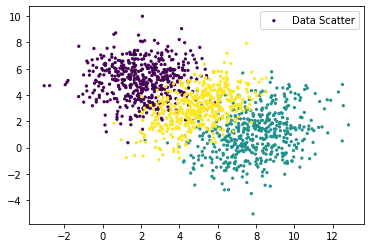

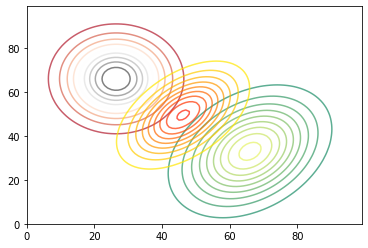

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


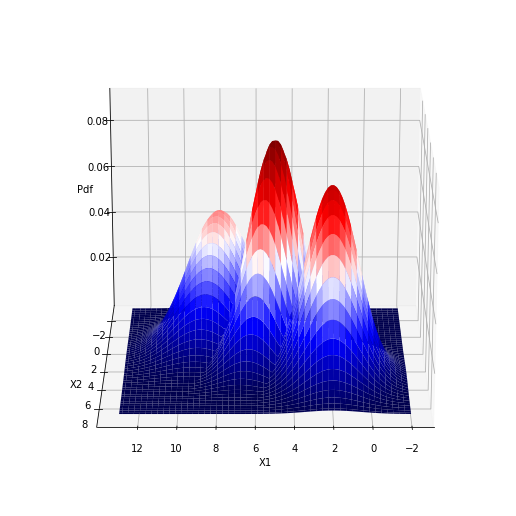

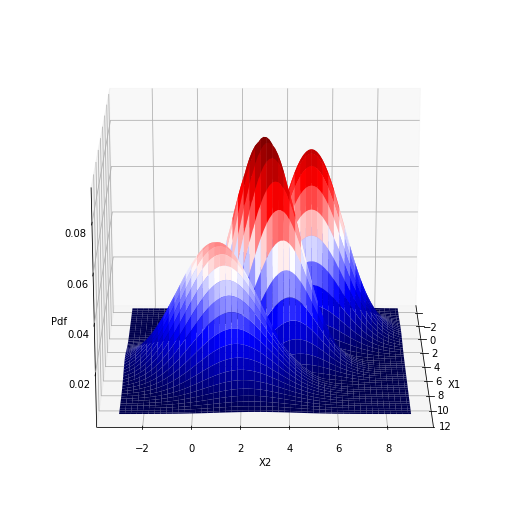

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:126: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


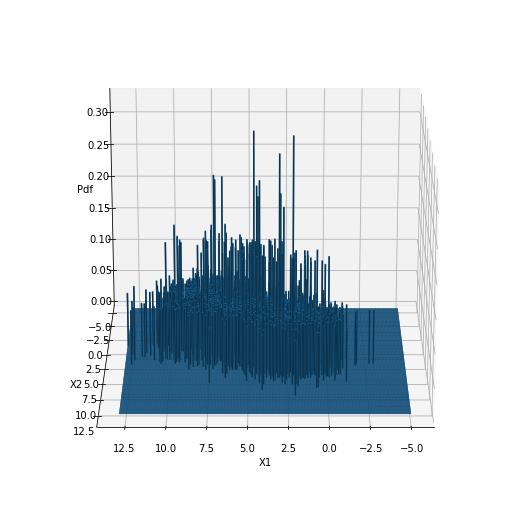

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:135: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


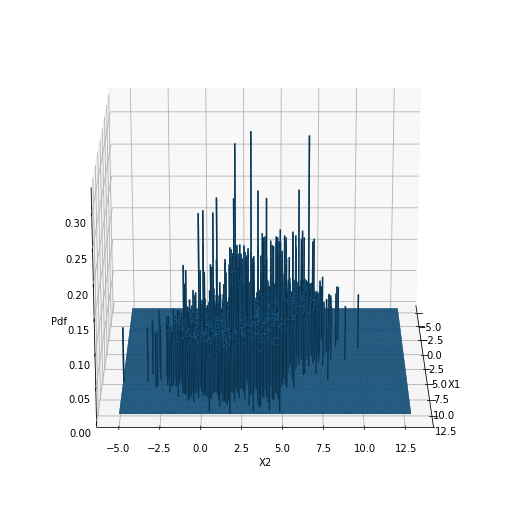

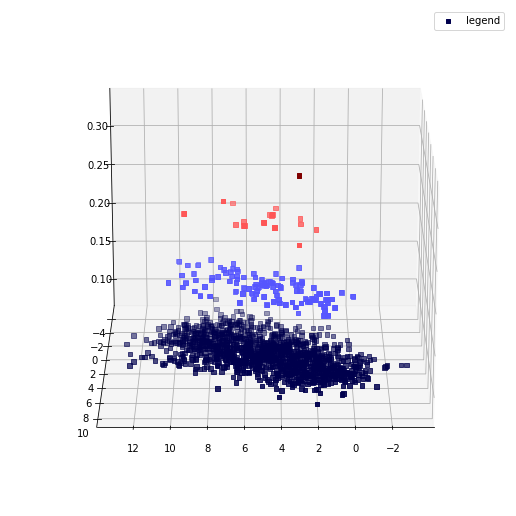

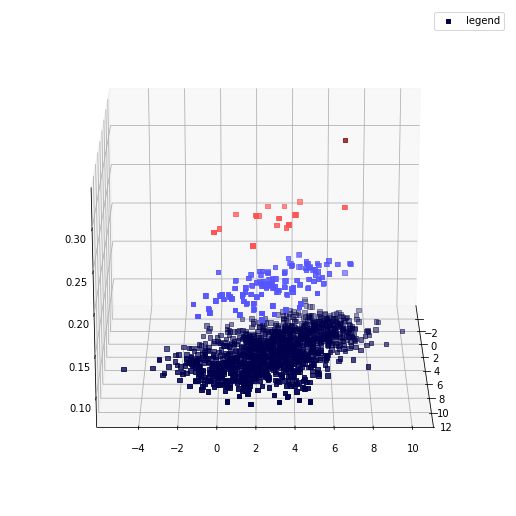

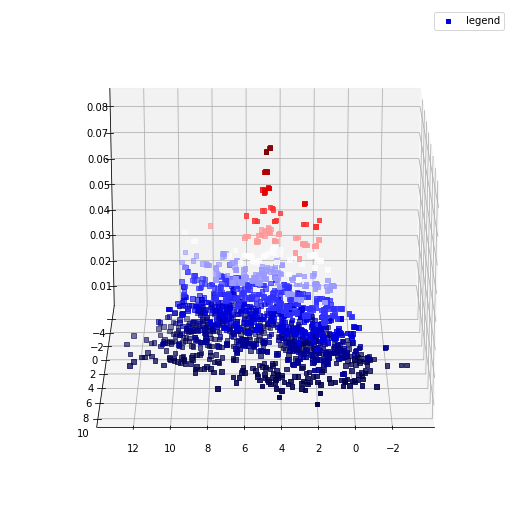

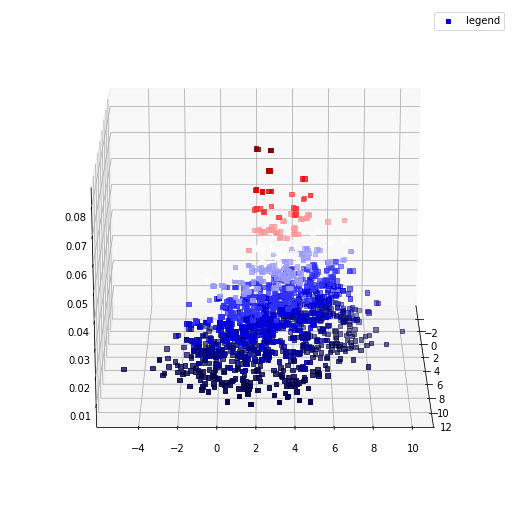

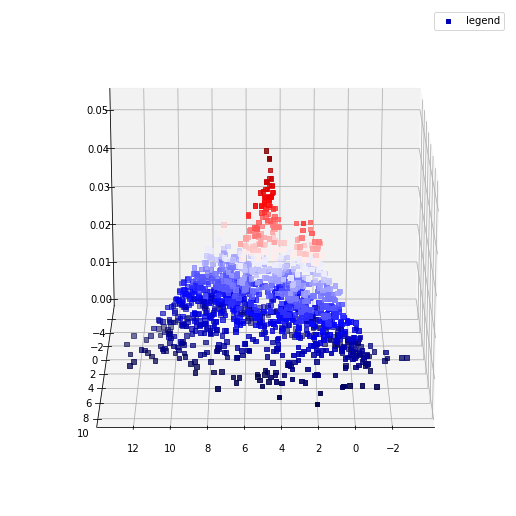

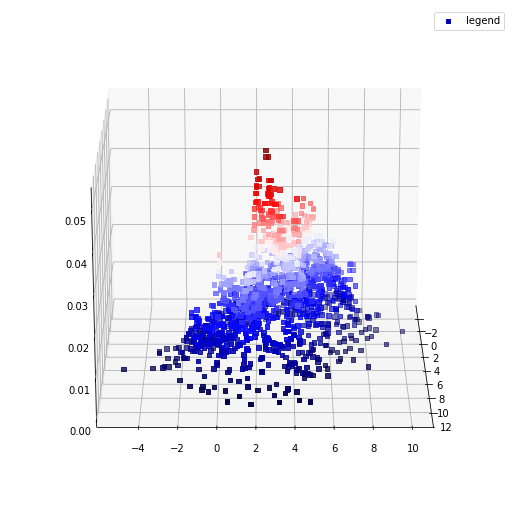

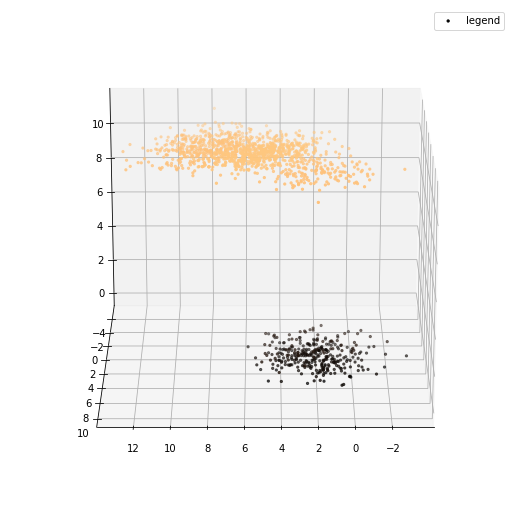

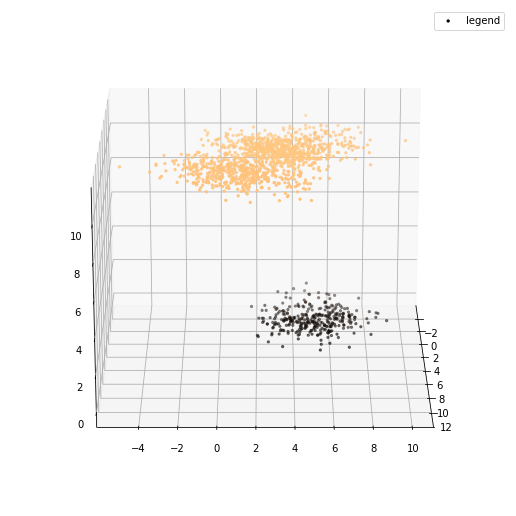

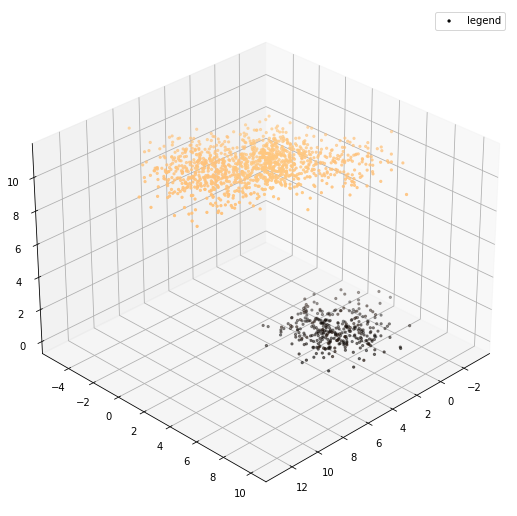

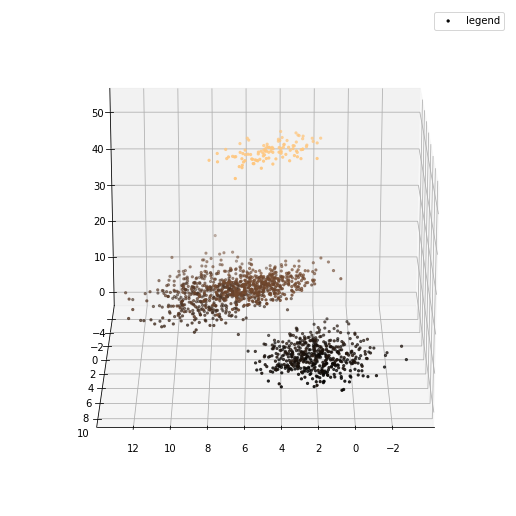

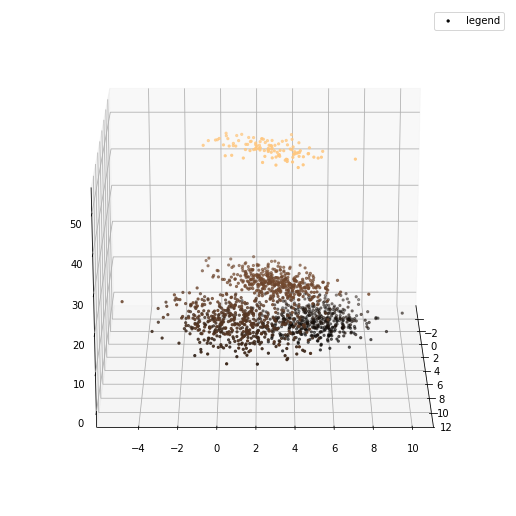

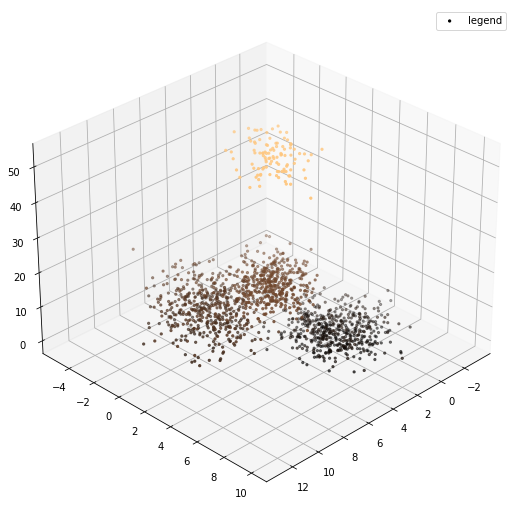

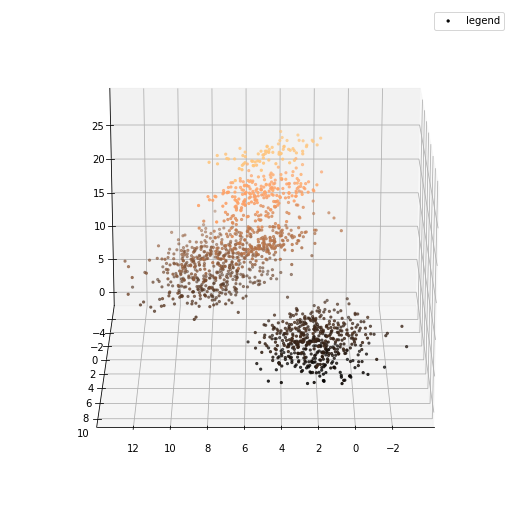

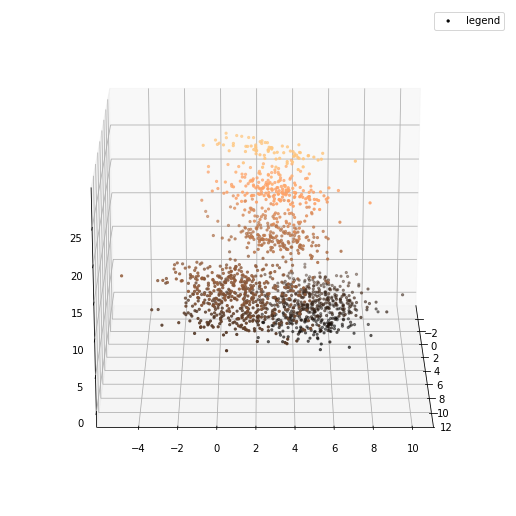

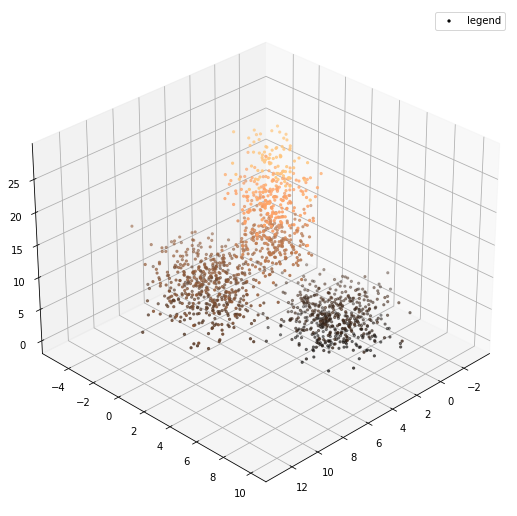

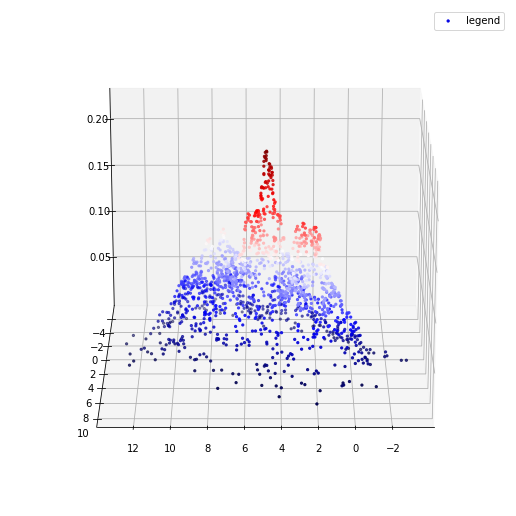

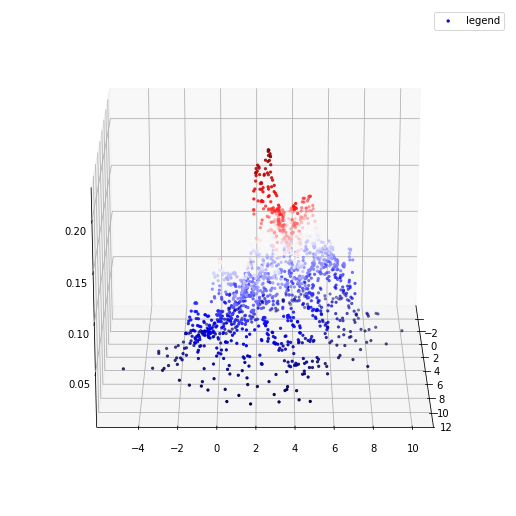

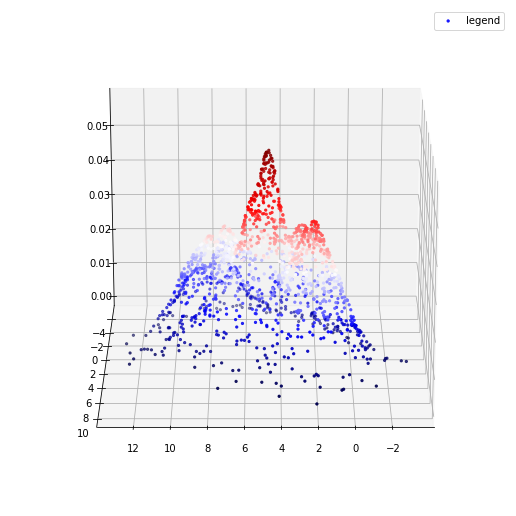

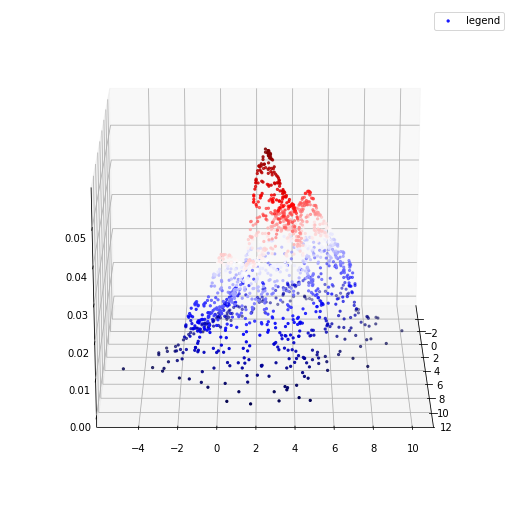

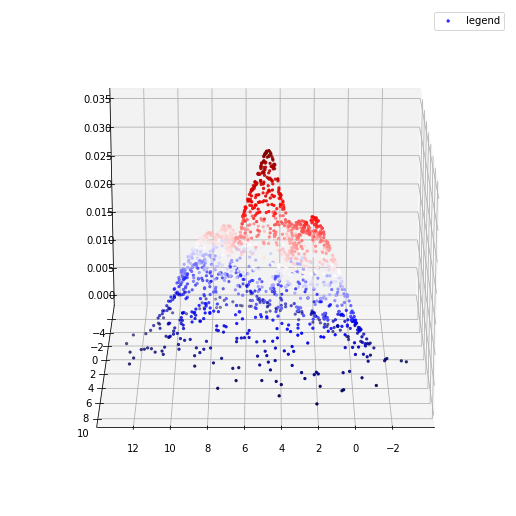

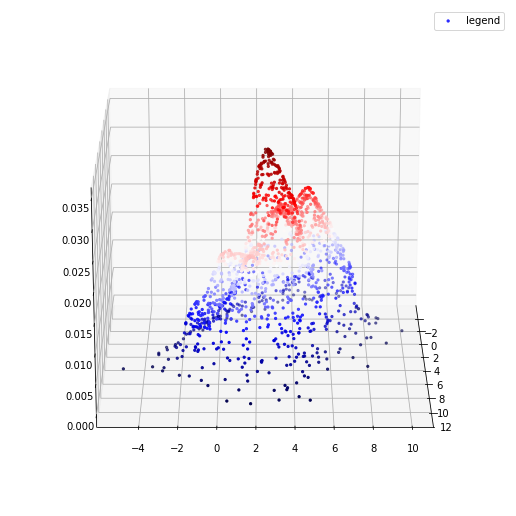

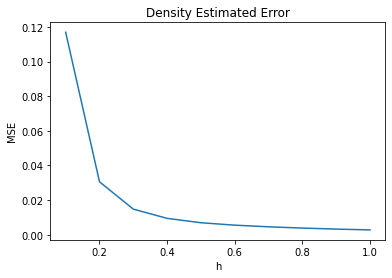

fi= [[0.33259259]
 [0.33259259]
 [0.33481481]]
mu= [[2.09825974 5.09580529]
 [7.89438657 1.00271581]
 [4.96128133 2.97643346]]
cov= [[[2.12160151 0.05703079]
  [0.05703079 2.11791712]]

 [[2.64777425 0.84700271]
  [0.84700271 2.97205844]]

 [[2.05605167 1.04694374]
  [1.04694374 2.0099703 ]]]
----------DataSet1----------
Train Accuracy =  0.902962962962963
Test Accuracy =  0.9


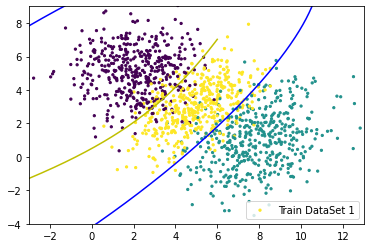

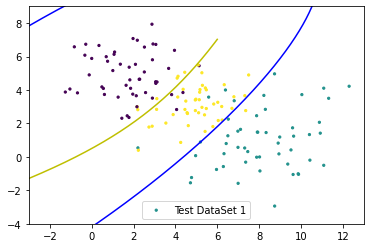

----------------------------


In [12]:
def RUN():
    #--------------------------------DataSet1----------------------------------#
    #-----------------generateData-----------------#    
    mu1 = [2, 5]
    cov1 = [[2  , 0  ],
            [0  , 2  ]]
    n1 = 500

    mu2 = [8, 1]
    cov2 = [[3  , 1  ],
            [1  , 3  ]] 
    n2 = 500

    mu3 = [5, 3]
    cov3 = [[2  , 1  ],
            [1  , 2  ]] 
    n3 = 500
    
    mu = np.zeros((3,2))
    cov = np.zeros((3,2,2))
    mu[0] = mu1
    mu[1] = mu2
    mu[2] = mu3
    cov[0] = cov1
    cov[1] = cov2
    cov[2] = cov3
    
    h = [0.09, 0.30, 0.60]
    
    cov_norm1 = [[0.2 , 0   ],
                 [0   , 0.2 ]] 
    cov_norm2 = [[0.6 , 0   ],
                 [0   , 0.6 ]] 
    cov_norm3 = [[0.9 , 0   ],
                 [0   , 0.9 ]] 
    cov_norm = np.zeros((3,2,2))
    cov_norm[0] = cov_norm1
    cov_norm[1] = cov_norm2
    cov_norm[2] = cov_norm3
    
    forks = [1, 9, 99]
    #-----------------Load Data----------------#
    x, y, m, k = load_data(mu1, cov1, n1, mu2, cov2, n2, mu3, cov3, n3)
    print('Cov[] = ', cov)
    print('Mu[] = ', mu)
    plot_scatter(x, y, 'Data Scatter')
    plot_pdf_contour(x, mu, cov, 'Data Contour')    
    plot_pdf_3d(x, mu, cov, v_angle=20, h_angle=90)
    plot_pdf_3d(x, mu, cov, v_angle=20, h_angle=0)
    #----------------Histogram-----------------#
    px = Histogram(x, h)
    #------------------Parzen------------------#
    px = Parzen(x, h)
    #-------------------KNN--------------------#
    px = KNN(x, forks)
    #--------------GaussianKernel--------------#    
    px = GaussianKernel(x, cov_norm, h=0.5)
    #--------FindBest_h--------#
    mse = FindBest_h(x, y, [cov_norm2])
    #---------Predict----------#
    test_size = 0.10
    x, y, m, xtest, ytest, mtest, k = split_data(x, y, test_size)
    #---------Learning---------#
    fi, mu, cov = qda_learn(x, y, m, k, x.shape[1])    
    #---------Predict----------#
    px_train = GaussianKernel(x, [cov_norm2], showplot=False)
    px_test = GaussianKernel(xtest, [cov_norm2], showplot=False)
    pyx_train, y_pred_train = predict(px_train, fi, mu, cov, x, m, k)    
    pyx_test, y_pred_test  = predict(px_test, fi, mu, cov, xtest, mtest, k)
    #---------Results----------#
    train_accuracy = accuracy_score(y, y_pred_train)
    test_accuracy = accuracy_score(ytest, y_pred_test)
    print('----------DataSet1----------')
    print('Train Accuracy = ',train_accuracy)
    print('Test Accuracy = ',test_accuracy) 
    #----------plots-----------#    
    draw_decision_boundaries(fi, mu, cov, x, 1, 1)    
    plot_scatter(x, y, 'Train DataSet 1')
    draw_decision_boundaries(fi, mu, cov, x, 1, 1)
    plot_scatter(xtest, ytest, 'Test DataSet 1')
    print('----------------------------')    
    #--------------------------------------------------------------------------#
    
    
RUN()